In [4]:
!pip install datasets

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import time
from datasets import Dataset
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
data = pd.read_csv("results.csv")

print(data.head(5))
print(len(data))

                                                text  label  source   model  \
0  \nThe English king Henry II was famously invol...      1  reddit  cohere   
1  \nThe Louisiana Purchase was a major land deal...      1  reddit  cohere   
2  \nSome historical cultures engaged in the prac...      1  reddit  cohere   
3  \nWatergate is the name of the scandal surroun...      1  reddit  cohere   
4  \nIf a king fell in battle, it was considered ...      1  reddit  cohere   

   mean_entropy  perplexity  mc_entropy  mahalanobis  
0      0.003930    2.342085    102.1250  2060.443891  
1      0.002794    1.800920    138.2500  2183.467985  
2      0.002914    1.917719     71.6250  2860.965447  
3      0.002758    1.826751    154.2500  2328.950104  
4      0.004240    2.664273    106.8125  1918.873293  
7000


In [7]:
metrics = ['mean_entropy', 'perplexity', 'mc_entropy', 'mahalanobis']

results = []

for metric in metrics:
    grouped = data.groupby('label')[metric].describe()
    for label in grouped.index:
        stats = grouped.loc[label]
        results.append({
            'Metric': metric,
            'Label': label,
            'Mean': f"{stats['mean']:.4f}",
            'Median': f"{data[data['label']==label][metric].median():.4f}",
            'Std': f"{stats['std']:.4f}",
            'Min': f"{stats['min']:.4f}",
            'Max': f"{stats['max']:.4f}"
        })

results_df = pd.DataFrame(results)

from tabulate import tabulate
print(tabulate(results_df, headers='keys', tablefmt='psql', showindex=False))

+--------------+---------+-----------+-----------+----------+----------+-----------+
| Metric       |   Label |      Mean |    Median |      Std |      Min |       Max |
|--------------+---------+-----------+-----------+----------+----------+-----------|
| mean_entropy |       0 |    0.0045 |    0.0045 |   0.0005 |   0.0023 |    0.006  |
| mean_entropy |       1 |    0.0034 |    0.0035 |   0.0009 |   0.0004 |    0.0067 |
| perplexity   |       0 |    2.6851 |    2.6658 |   0.3378 |   1.6291 |    3.89   |
| perplexity   |       1 |    2.1756 |    2.137  |   0.4377 |   1.0716 |    4.5481 |
| mc_entropy   |       0 |  429.206  |  452.375  | 115.155  | 164.375  |  695.5    |
| mc_entropy   |       1 |  216.063  |  190.125  |  98.2335 |  19.0625 |  674.5    |
| mahalanobis  |       0 | 1465.92   | 1400.88   | 350.174  | 357.836  | 4817.47   |
| mahalanobis  |       1 | 2029.66   | 1983.84   | 469.339  | 996.327  | 6088.49   |
+--------------+---------+-----------+-----------+----------+----

In [8]:
models = data['model'].unique()
train_dfs = []
test_dfs = []

In [9]:
for model in models:
    model_data = data[data['model'] == model]
    train, test = train_test_split(model_data, test_size=0.2, random_state=42)
    train_dfs.append(train)
    test_dfs.append(test)

train_data = pd.concat(train_dfs)
test_data = pd.concat(test_dfs)

In [10]:
features = ['mean_entropy', 'perplexity', 'mc_entropy', 'mahalanobis']
X_train = train_data[features].values
y_train = train_data['label'].values
X_test = test_data[features].values
y_test = test_data['label'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [11]:
class AdvancedBinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = AdvancedBinaryClassifier(len(features))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
train_losses = []
test_losses = []

In [12]:
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
total_time = time.time() - start_time

Epoch 5/50 - Train Loss: 0.2226, Test Loss: 0.2163
Epoch 10/50 - Train Loss: 0.2175, Test Loss: 0.2069
Epoch 15/50 - Train Loss: 0.2130, Test Loss: 0.2035
Epoch 20/50 - Train Loss: 0.2141, Test Loss: 0.2024
Epoch 25/50 - Train Loss: 0.2063, Test Loss: 0.1990
Epoch 30/50 - Train Loss: 0.2052, Test Loss: 0.1961
Epoch 35/50 - Train Loss: 0.2072, Test Loss: 0.1963
Epoch 40/50 - Train Loss: 0.2045, Test Loss: 0.1983
Epoch 45/50 - Train Loss: 0.2041, Test Loss: 0.1919
Epoch 50/50 - Train Loss: 0.2004, Test Loss: 0.1933


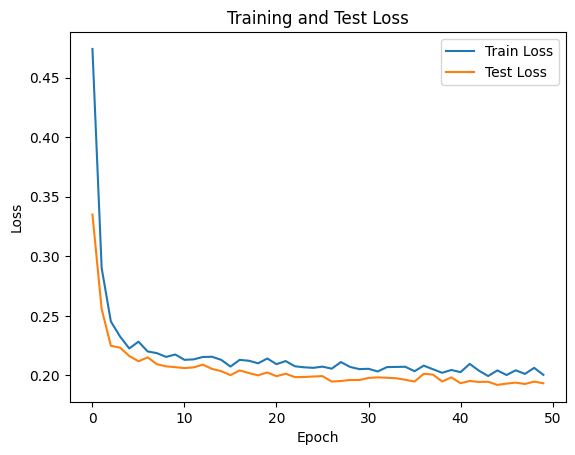

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

classifier_metrics = {}
classifier_metrics["Accuracy"] = accuracy
classifier_metrics["Precision"] = precision
classifier_metrics["Recall"] = recall
classifier_metrics["Train Time"] = total_time

In [14]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

X_train = train_data[['text', 'label']]
X_test = test_data[['text', 'label']]

train_dataset = Dataset.from_pandas(X_train)
test_dataset = Dataset.from_pandas(X_test)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)
training_args.report_to = []


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)
start_time = time.time()
trainer.train()
total_time = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.126600,0.064626


In [15]:
def classify_text(text, device = "cuda"):
    model.to(device)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

true_labels = []
predicted_labels = []

for i, row in test_data.iterrows():
    text = row["text"]
    true_label = row["label"]
    predicted_label = classify_text(text)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

BERT_classifier_metrics = {}
BERT_classifier_metrics["Accuracy"] = accuracy
BERT_classifier_metrics["Precision"] = precision
BERT_classifier_metrics["Recall"] = recall
BERT_classifier_metrics["Train Time"] = total_time

In [16]:
metrics = {
    'BERT_Classifier': BERT_classifier_metrics,
    'Neural_Classifier_with_uncertainty': classifier_metrics
}

df = pd.DataFrame(metrics).T.round(4)
print(df)

                                    Accuracy  Precision  Recall  Train Time
BERT_Classifier                       0.9907     0.9901  0.9992    594.4377
Neural_Classifier_with_uncertainty    0.9136     0.9455  0.9542     30.1410
